In [1]:
import numpy as np

import torch
from torch import nn, optim
import torch.nn.functional as F

import matplotlib.pyplot as plt

torch.set_printoptions(sci_mode = False, precision = 4)

In [2]:
# Hyperparameters
class HParams:
    def __init__(self):
        
        # Problem params
        self.num_agents = 2
        self.num_states = 2
        self.num_signals = 2
        
        self.theta = np.array([0.75, 0.25])
        self.alpha = 0.5
        
        # Minibatch size
        self.batch_size = 1024
        self.num_misreports = 100
        
        
        # Number of layer
        self.R = 3
        # Number of hidden units
        self.K = 200
        
        # Data - Choose among exp, uniform, assymetric_uniform, irregular
        self.distr_type = "exp"
        
        # Opt params
        self.lr = 1e-3
        
        self.gd_lr = 5e-3
        self.gd_iter = 0
        
        self.temp = 0.1
        
        # Lagrangian params
        self.lag_ic_init = 1
        self.lag_up_iter = 100
        
        self.pho_init = 1
        self.pho_increment = 10
        self.pho_up_iter = 1000
        
        # Miscellaneous
        self.seed = 0
                  
        self.max_iter = 20000 
        self.print_iter = 1000
        
        
        """ Test params """
        self.test_batch_size = 1024
        self.test_num_misreports = 100
        self.test_num_batches = 200
        self.test_gd_lr =  5e-3
        self.test_gd_iter = 100
        
                
# Initialize config
cfg = HParams()
np.random.seed(cfg.seed)

# Asserts
assert(cfg.num_agents == 2)
device = "cuda"

np.random.seed(cfg.seed)

In [3]:
def sample_batch(batch_size):
    shape = (batch_size, cfg.num_agents)
    return np.random.rand(*shape)

In [4]:
# Utils
def torch_var(x): return torch.Tensor(x).to(device)
def numpy_var(x): return x.detach().cpu().numpy()

In [5]:
# TODO: Initializations, Softmax temperatures

class ActionNet(nn.Module):      
    def __init__(self, cfg):
        super(ActionNet, self).__init__()
        self.cfg = cfg
        
        num_agents = self.cfg.num_agents
        num_states = self.cfg.num_states
        num_signals = self.cfg.num_signals
        
        num_layers = self.cfg.R
        num_hidden_nodes = self.cfg.K
        
        self.theta = torch_var(self.cfg.theta)[:, None]
        self.temp = torch_var([self.cfg.temp])

        self.pi = nn.ModuleList()
        
        # Input layer
        m = nn.Linear(num_agents, num_hidden_nodes)
        nn.init.xavier_uniform_(m.weight.data, gain = nn.init.calculate_gain('leaky_relu'))
        nn.init.constant_(m.bias, 0)
        self.pi.append(m)
        self.pi.append(nn.LeakyReLU())
        
        # Hidden layers
        for i in range(num_layers - 1):
            m = nn.Linear(num_hidden_nodes, num_hidden_nodes)
            nn.init.xavier_uniform_(m.weight.data, gain = nn.init.calculate_gain('leaky_relu'))
            nn.init.constant_(m.bias, 0)
            self.pi.append(m)
            self.pi.append(nn.LeakyReLU())
         
        # Output layer
        m = nn.Linear(num_hidden_nodes, num_agents * num_states * num_signals)
        nn.init.xavier_uniform_(m.weight.data, gain = nn.init.calculate_gain('sigmoid'))
        nn.init.constant_(m.bias, 0)
        self.pi.append(m)

    def forward(self, v):
        out = v
        for module in self.pi: out = module(out)
        out = out.view(-1, self.cfg.num_agents, self.cfg.num_states, self.cfg.num_signals)
        pi =  F.softmax(out / self.temp, dim = -1)
        return torch.max(pi * self.theta, axis = -2)[0].sum(axis = -1)
    
    
class PayNet(nn.Module):     
    def __init__(self, cfg):
        super(PayNet, self).__init__()
        self.cfg = cfg                
        num_agents = self.cfg.num_agents
        num_layers = self.cfg.R
        num_hidden_nodes = self.cfg.K

        self.pay = nn.ModuleList()
        
        # Input layer
        m = nn.Linear(num_agents, num_hidden_nodes)
        nn.init.xavier_uniform_(m.weight.data, gain = nn.init.calculate_gain('leaky_relu'))
        nn.init.constant_(m.bias, 0)
        self.pay.append(m)
        self.pay.append(nn.LeakyReLU())
        
        # Hidden layers
        for i in range(num_layers - 1):
            m = nn.Linear(num_hidden_nodes, num_hidden_nodes)
            nn.init.xavier_uniform_(m.weight.data, gain = nn.init.calculate_gain('leaky_relu'))
            nn.init.constant_(m.bias, 0)
            self.pay.append(m)
            self.pay.append(nn.LeakyReLU())

         
        # Output layer
        m = nn.Linear(num_hidden_nodes, num_agents)
        nn.init.xavier_uniform_(m.weight.data, gain = nn.init.calculate_gain('sigmoid'))
        nn.init.constant_(m.bias, 0)
        self.pay.append(m)
                
    def forward(self, v):
        out = v
        for module in self.pay: out = module(out)
        return v * torch.sigmoid(out)

In [6]:
def compute_utility(x):
    u = (1 + cfg.alpha) * x - cfg.alpha * x.sum(axis = -1, keepdim=True)
    return u

In [7]:
def compute_payments(x, p_frac):
    """
    Computes payments
    Args:
        x: [Batch, num_agents]
    Returns:
        pay: [Batch, num_agents]
    """
    
    u_in = compute_utility(x)
    u_out = (max(cfg.theta) - cfg.alpha)  
    return p_frac * (u_in - u_out)

In [8]:
def compute_misreports_samples(b, v, u):
    
    ic_viol = torch.zeros(cfg.num_agents).to(device)
    
    batch_size, num_misreports = b.shape[0], b.shape[1]
    v_mis = v[:, None, :].repeat(1, num_misreports, 1)
    
    
    best_b = torch.zeros(batch_size, cfg.num_agents).to(device)
    
    # Compute IC violation for each agent
    for i in range(cfg.num_agents):  
        
        # Compose misreport of shape: [batch_size, num_misreports, num_agents]
        b_mis = torch.cat((v_mis[:, :, :i], b[:, :, i: i + 1], v_mis[:, :, i + 1:]), axis = -1)
        b_mis = b_mis.view(-1, cfg.num_agents)
        
        # Compute action_mis, pay_mis
        x_mis = action_net(b_mis)
        p_mis = compute_payments(x_mis, pay_net(b_mis))
        
        
        # BS x NM: 12800
        w_mis = (1 + cfg.alpha) * x_mis[:, i] - cfg.alpha * x_mis.sum(axis = -1)
        u_mis = v_mis[:, :, i].reshape(-1) * w_mis - p_mis[:, i]
        u_mis = u_mis.reshape(-1, num_misreports)

        u_mis, b_mis_idx = u_mis.max(axis = -1)
        best_b[:, i] = b[:, :, i][torch.arange(b.shape[0]), b_mis_idx]
        ic_viol[i] += F.relu(u_mis - u[:, i]).mean()
        
        
    return ic_viol, best_b

In [9]:
def compute_misreports_gd(b_var, v, gd_lr = 5e-3, gd_iter = 100):
    
    # Autograd variables
    b_var = b_var.detach().clone()
    b_var.requires_grad_(True)
    
    # Optimizer
    opt = torch.optim.Adam([b_var], lr = gd_lr)
    
    for it in range(gd_iter):
        
        opt.zero_grad()
        u_mis = torch.zeros(cfg.num_agents).to(device)
        
        for i in range(cfg.num_agents):
            
            b_mis = torch.cat((v[:, :i], b_var[:, i: i + 1], v[:, i + 1:]), axis = -1)
            
            x_mis = action_net(b_mis)
            p_mis = compute_payments(x_mis, pay_net(b_mis))
            
            w_mis = (1 + cfg.alpha) * x_mis[:, i] - cfg.alpha * x_mis.sum(axis = -1)
            u_mis[i] = (v[:, i] * w_mis - p_mis[:, i]).sum()

            
        u_mis_loss = (-u_mis.sum())
        u_mis_loss.backward(inputs = b_var)
        opt.step()        
        b_var.data.clamp_(min = 0.0, max = 1.0)
        
        
    return b_var.detach().clone()

In [10]:
def compute_ic_viol(b_var, v, u):
    
    ic_viol = torch.zeros(cfg.num_agents).to(device)
    
    # Compute IC violation for each agent
    for i in range(cfg.num_agents):  
        
        # Compose misreport of shape: [batch_size, num_misreports, num_agents]
        b_mis = torch.cat((v[:, :i], b_var[:, i: i + 1], v[:, i + 1:]), axis = -1)
        
        # Compute action_mis, pay_mis
        x_mis = action_net(b_mis)
        p_mis = compute_payments(x_mis, pay_net(b_mis))
        
        w_mis = (1 + cfg.alpha) * x_mis[:, i] - cfg.alpha * x_mis.sum(axis = -1)
        u_mis = v[:, i] * w_mis - p_mis[:, i]
        ic_viol[i] += F.relu((u_mis - u[:, i])/(v[:, i] + 1e-8)).mean()
        
    return ic_viol

In [11]:
action_net = ActionNet(cfg).to(device)
pay_net = PayNet(cfg).to(device)
# Keep in mind that if the distributions are asymetric, we need two different neural networks

In [12]:
lag_ic_init = cfg.lag_ic_init
w_ic = torch.ones(cfg.num_agents).to(device) * lag_ic_init

pho = cfg.pho_init
pho_increment = cfg.pho_increment

opt = torch.optim.AdamW(list(action_net.parameters()) + list(pay_net.parameters()), lr=cfg.lr)

it = 1

In [13]:
import time
tic = time.time()
                                  
while it <= cfg.max_iter:
    
    opt.zero_grad()
    
    # Get batch
    V = sample_batch(cfg.batch_size)
    v = torch_var(V)
    
    x = action_net(v)
    pay = compute_payments(x, pay_net(v))
    
    # Compute Revenue
    revenue = pay.sum(axis = -1).mean()
    
    # Compute utility
    u = v * compute_utility(x) - pay
    
    # Compute IC-Violation
    
    with torch.set_grad_enabled(False):
        b = torch_var(sample_batch(cfg.batch_size * cfg.num_misreports).reshape(cfg.batch_size, cfg.num_misreports, -1))
        _, b_var = compute_misreports_samples(b, v, u)
        
    b_var = compute_misreports_gd(b_var, v, gd_lr = cfg.gd_lr, gd_iter = cfg.gd_iter)
    ic_viol = compute_ic_viol(b_var, v, u)
     
    # Compute Loss
    rev_loss = -revenue
    lagrangian = torch.dot(w_ic, ic_viol)
    penalty = pho * (ic_viol**2).sum()
    loss = rev_loss + penalty + lagrangian
    
    # GD Step
    loss.backward()   
    opt.step()
    
    if it % cfg.print_iter == 0:
        print("[Iter: %d], [Time Elapsed: %.2fs]"%(it, time.time() - tic))
        print("[Rev: %.4f], [IC Viol: %.4f]"%(revenue.sum(), ic_viol.mean().item()))
        
    if it % cfg.lag_up_iter == 0:
        w_ic.data += pho * ic_viol.data
        
    if it % cfg.pho_up_iter == 0:
        pho += pho_increment
        
    it += 1

[Iter: 1000], [Time Elapsed: 111.78s]
[Rev: 0.1848], [IC Viol: 0.0116]
[Iter: 2000], [Time Elapsed: 172.82s]
[Rev: 0.1685], [IC Viol: 0.0049]
[Iter: 3000], [Time Elapsed: 231.13s]
[Rev: 0.1583], [IC Viol: 0.0025]
[Iter: 4000], [Time Elapsed: 289.44s]
[Rev: 0.1523], [IC Viol: 0.0015]
[Iter: 5000], [Time Elapsed: 348.66s]
[Rev: 0.1547], [IC Viol: 0.0011]
[Iter: 6000], [Time Elapsed: 409.37s]
[Rev: 0.1451], [IC Viol: 0.0010]
[Iter: 7000], [Time Elapsed: 469.72s]
[Rev: 0.1456], [IC Viol: 0.0007]
[Iter: 8000], [Time Elapsed: 530.67s]
[Rev: 0.1446], [IC Viol: 0.0006]
[Iter: 9000], [Time Elapsed: 590.40s]
[Rev: 0.1523], [IC Viol: 0.0006]
[Iter: 10000], [Time Elapsed: 649.94s]
[Rev: 0.1430], [IC Viol: 0.0005]
[Iter: 11000], [Time Elapsed: 709.72s]
[Rev: 0.1455], [IC Viol: 0.0005]
[Iter: 12000], [Time Elapsed: 768.24s]
[Rev: 0.1430], [IC Viol: 0.0005]
[Iter: 13000], [Time Elapsed: 827.82s]
[Rev: 0.1441], [IC Viol: 0.0004]
[Iter: 14000], [Time Elapsed: 887.36s]
[Rev: 0.1488], [IC Viol: 0.0003]
[

In [14]:
# Optimal
def phi(v): return 2*v - 1
def phi_inv(v): return (v-1)/2 + 1

def compute_opt_payment(V): 
    theta = max(cfg.theta)
    P = np.zeros(V.shape)
    for i in range(len(V)):
        v1, v2 = V[i]
        r1 = max(0, phi_inv(1/cfg.alpha * phi(v2)))
        r2 = max(0, phi_inv(cfg.alpha * phi(v2)))
        if v2 <= phi_inv(0):
            P[i, 0] += (r2 * (v1 >= r2) + r1 * cfg.alpha * (v1 >= r1)) * (1 - theta)
        else:
            P[i, 0] += (r1 * cfg.alpha * (v1 >= r1) + r2 * (v1 >= r2)) * (1 - theta)
            
        v2, v1 = V[i]
        r1 = max(0, phi_inv(1/cfg.alpha * phi(v2)))
        r2 = max(0, phi_inv(cfg.alpha * phi(v2)))
        if v2 <= phi_inv(0):
            P[i, 1] += (r2 * (v1 >= r2) + r1 * cfg.alpha * (v1 >= r1)) * (1 - theta)
        else:
            P[i, 1] += (r1 * cfg.alpha * (v1 >= r1) + r2 * (v1 >= r2)) * (1 - theta)
    return P

with torch.no_grad():
    REV = 0
    IC_viol = 0   
    OPT_REV = 0
    
    for i in range(cfg.test_num_batches):
        
        V = sample_batch(cfg.test_batch_size)
        v = torch_var(V)
        
        x = action_net(v)
        pay = compute_payments(x, pay_net(v))
        u = v * ((1 + cfg.alpha) * x - cfg.alpha * x.sum(axis = -1, keepdim=True)) - pay
        
        b = torch_var(sample_batch(cfg.test_batch_size * cfg.test_num_misreports).reshape(cfg.test_batch_size, cfg.test_num_misreports, -1))
        _, b_var = compute_misreports_samples(b, v, u)
    
    
        #with torch.set_grad_enabled(True):
        #    b_var = compute_misreports_gd(b_var, v, gd_lr = cfg.test_gd_lr, gd_iter = cfg.test_gd_iter)
    
        
        ic_viol = compute_ic_viol(b_var, v, u)
    

        revenue = pay.sum(-1).mean()   
        
        REV += revenue.item()
        IC_viol += ic_viol.mean().item()
        OPT_REV += compute_opt_payment(V).sum(-1).mean()
        
    OPT_REV = OPT_REV/cfg.test_num_batches
    REV = REV/cfg.test_num_batches
    IC_viol = IC_viol/cfg.test_num_batches
    
print("Rev: %.4f, IC_viol: %.4f, OPT_REV: %.4f"%(REV, IC_viol, OPT_REV))

Rev: 0.1404, IC_viol: 0.0002, OPT_REV: 0.1352


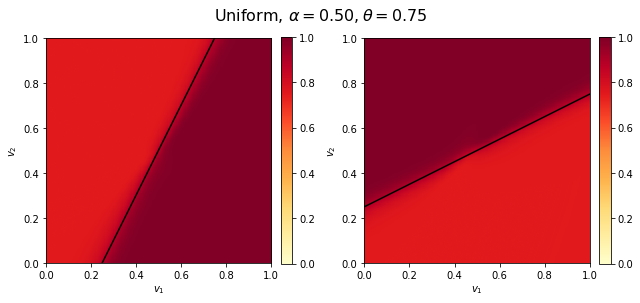

In [15]:
v = torch_var(np.linspace(0, 1, 201))
v_mesh = torch.stack(torch.meshgrid(v, v, indexing = "ij"), axis = -1)
x_mesh = action_net(v_mesh.view(-1, 2)).view(201, 201, 2)
AM = numpy_var(x_mesh)

fig, ax = plt.subplots(ncols = 2, nrows = 1, figsize=(9,4))

img_1 = ax[0].imshow(AM[:, :, 0].transpose(1,0), extent=[0,1,0,1], vmin = 0.0, vmax=1.0, cmap = 'YlOrRd', origin = "lower")
plt.colorbar(img_1, ax = ax[0], fraction=0.046, pad=0.04)

img_2 = ax[1].imshow(AM[:, :, 1].transpose(1,0), extent=[0,1,0,1], vmin = 0.0, vmax=1.0, cmap = 'YlOrRd', origin = "lower")
plt.colorbar(img_2, ax = ax[1], fraction=0.046, pad=0.04)



ax[0].plot([0.25, 0.75],[0, 1],color='black')
ax[1].plot([0, 1], [0.25, 0.75], color='black')

ax[0].set_xlabel("$v_1$")
ax[0].set_ylabel("$v_2$")
ax[1].set_xlabel("$v_1$")
ax[1].set_ylabel("$v_2$")

fig.text(0.5, 1, r"Uniform, $\alpha=%.2f, \theta=%.2f$"%(cfg.alpha, max(cfg.theta)), ha='center', size = 16)
fig.tight_layout()
plt.savefig("DSIC_U_theta_%.2f_alpha_%.2f.pdf"%(max(cfg.theta), cfg.alpha), bbox_inches = "tight")